## intro

In this project, i'll build a music recommendor from data of users listening to a song repetitively after the first observable listening event within a time window. If there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, its target is marked 1, and 0 otherwise in the training set. The same rule applies to the testing set.

KKBOX provides a training data set consists of information of the first observable listening event for each unique user-song pair within a specific time duration. Metadata of each unique user and song pair is also provided. The use of public data to increase the level of accuracy of prediction.

The train and the test data are selected from users listening history in a given time period. Note that this time period is chosen to be before the WSDM-KKBox Churn Prediction time period. The train and test sets are split based on time, and the split of public/private are based on unique user/song pairs.

## Tables 

### train.csv
msno: user id
song_id: song id
source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name: name of the layout a user sees.
source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .
### test.csv
id: row id (will be used for submission)
msno: user id
song_id: song id
source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name: name of the layout a user sees.
source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.

### sample_submission.csv
sample submission file in the format that will be submit

id: same as id in test.csv
target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

### songs.csv
The songs. Note that data is in unicode.

song_id
song_length: in ms
genre_ids: genre category. Some songs have multiple genres and they are separated by |
artist_name
composer
lyricist
language

### members.csv
user information.

msno
city
bd: age. Note: this column has outlier values, please use your judgement.
gender
registered_via: registration method
registration_init_time: format %Y%m%d
expiration_date: format %Y%m%d

### song_extra_info.csv
song_id
song name - the name of the song.
isrc - International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

In [135]:
#Importing required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [136]:
#Loading Datasets
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
songs=pd.read_csv('songs.csv')
songs_extra_info=pd.read_csv('song_extra_info.csv')
members=pd.read_csv('members.csv')

# Exploratory Data Analysis

In [137]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [223]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [224]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0.0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1.0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2.0,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3.0,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4.0,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [225]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52


In [226]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 6 columns):
msno                  19999 non-null object
song_id               19999 non-null object
source_system_tab     19932 non-null object
source_screen_name    19423 non-null object
source_type           19949 non-null object
target                19999 non-null int64
dtypes: int64(1), object(5)
memory usage: 937.6+ KB


In [227]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 6 columns):
id                    4999 non-null float64
msno                  4999 non-null object
song_id               4999 non-null object
source_system_tab     4996 non-null object
source_screen_name    4781 non-null object
source_type           4997 non-null object
dtypes: float64(1), object(5)
memory usage: 1.8+ MB


In [228]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 7 columns):
song_id        39999 non-null object
song_length    39999 non-null int64
genre_ids      39282 non-null object
artist_name    39999 non-null object
composer       23203 non-null object
lyricist       10913 non-null object
language       39999 non-null int64
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


#### plotting Source type

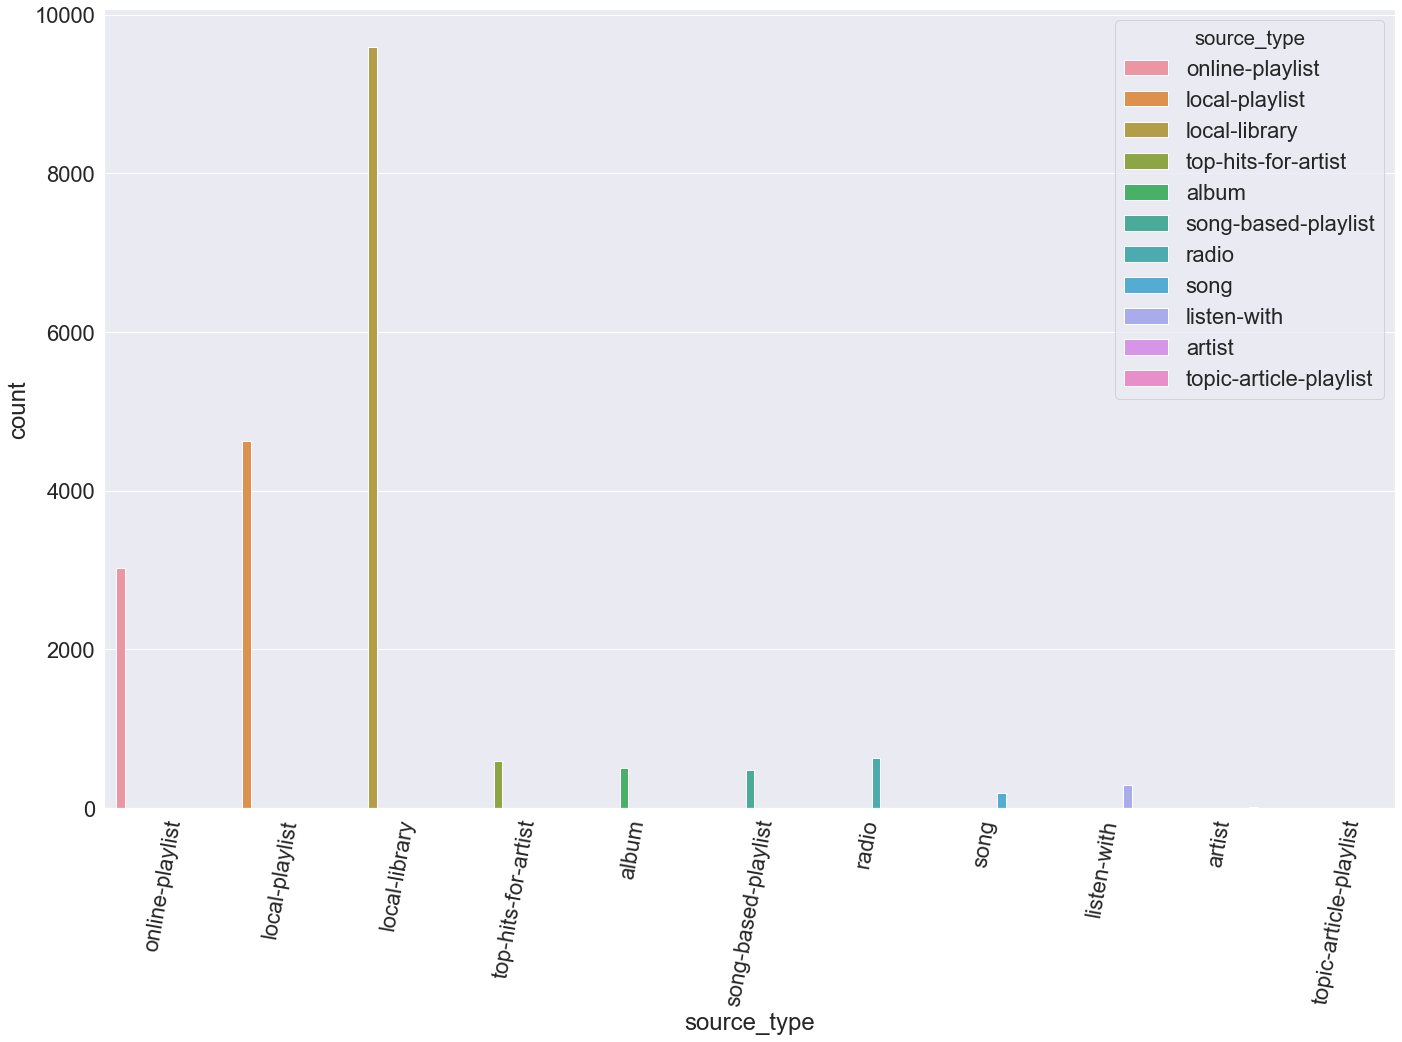

In [236]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
ax=sns.countplot(x='source_type',hue='source_type',data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=80)
plt.tight_layout()

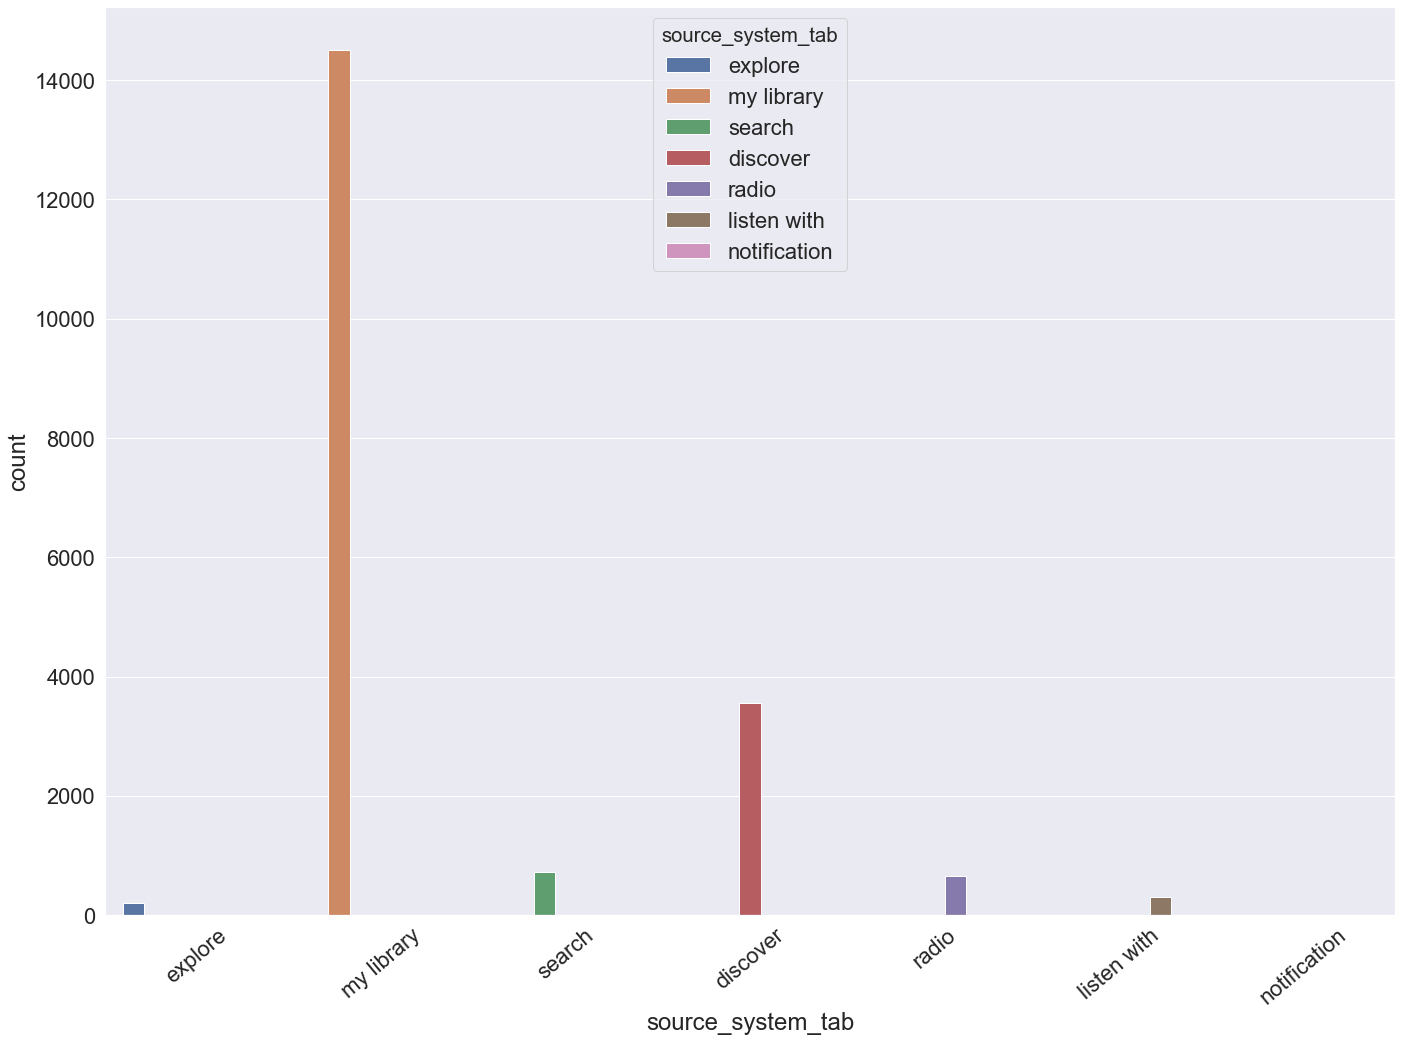

In [240]:
plt.figure(figsize=(20,15))
sns.set(font_scale=2)
ax=sns.countplot(x='source_system_tab',hue='source_system_tab',data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
plt.tight_layout()

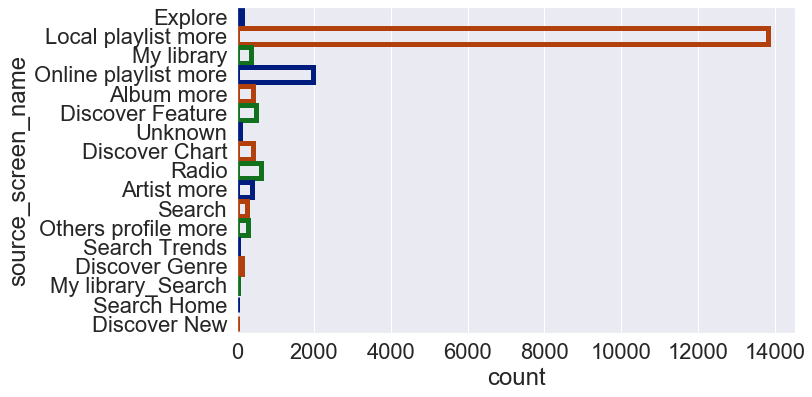

In [146]:
plt.figure(figsize=(10,6))
ax=sns.countplot(y='source_screen_name',data=train, facecolor=(0,0,0,0), linewidth =5,
                edgecolor= sns.color_palette('dark',3)) 

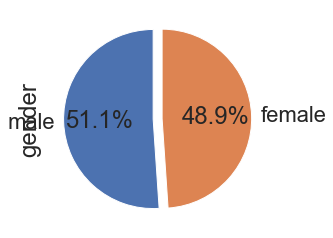

In [147]:
plt.figure(figsize=(5,5))
pp= pd.value_counts(members.gender)
pp.plot.pie(startangle=90, autopct='%1.1f%%', explode= (0.05,0.05))
plt.tight_layout()
plt.show()

# MERGING DATA FRAME

In [148]:
train_song=pd.merge(train,songs,on='song_id',how='left')
train_merged=pd.merge(train_song,members,on='msno',how='left')
train_merged.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,7,20120102,20171005


In [149]:
from pprint import pprint
pprint(train_merged.columns.to_series().groupby(train_merged.dtypes).groups)

{dtype('int64'): Index(['target', 'city', 'bd', 'registered_via', 'registration_init_time',
       'expiration_date'],
      dtype='object'),
 dtype('float64'): Index(['song_length', 'language'], dtype='object'),
 dtype('O'): Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'genre_ids', 'artist_name', 'composer', 'lyricist',
       'gender'],
      dtype='object')}


Text(0.5, 1.0, 'Registration Time')

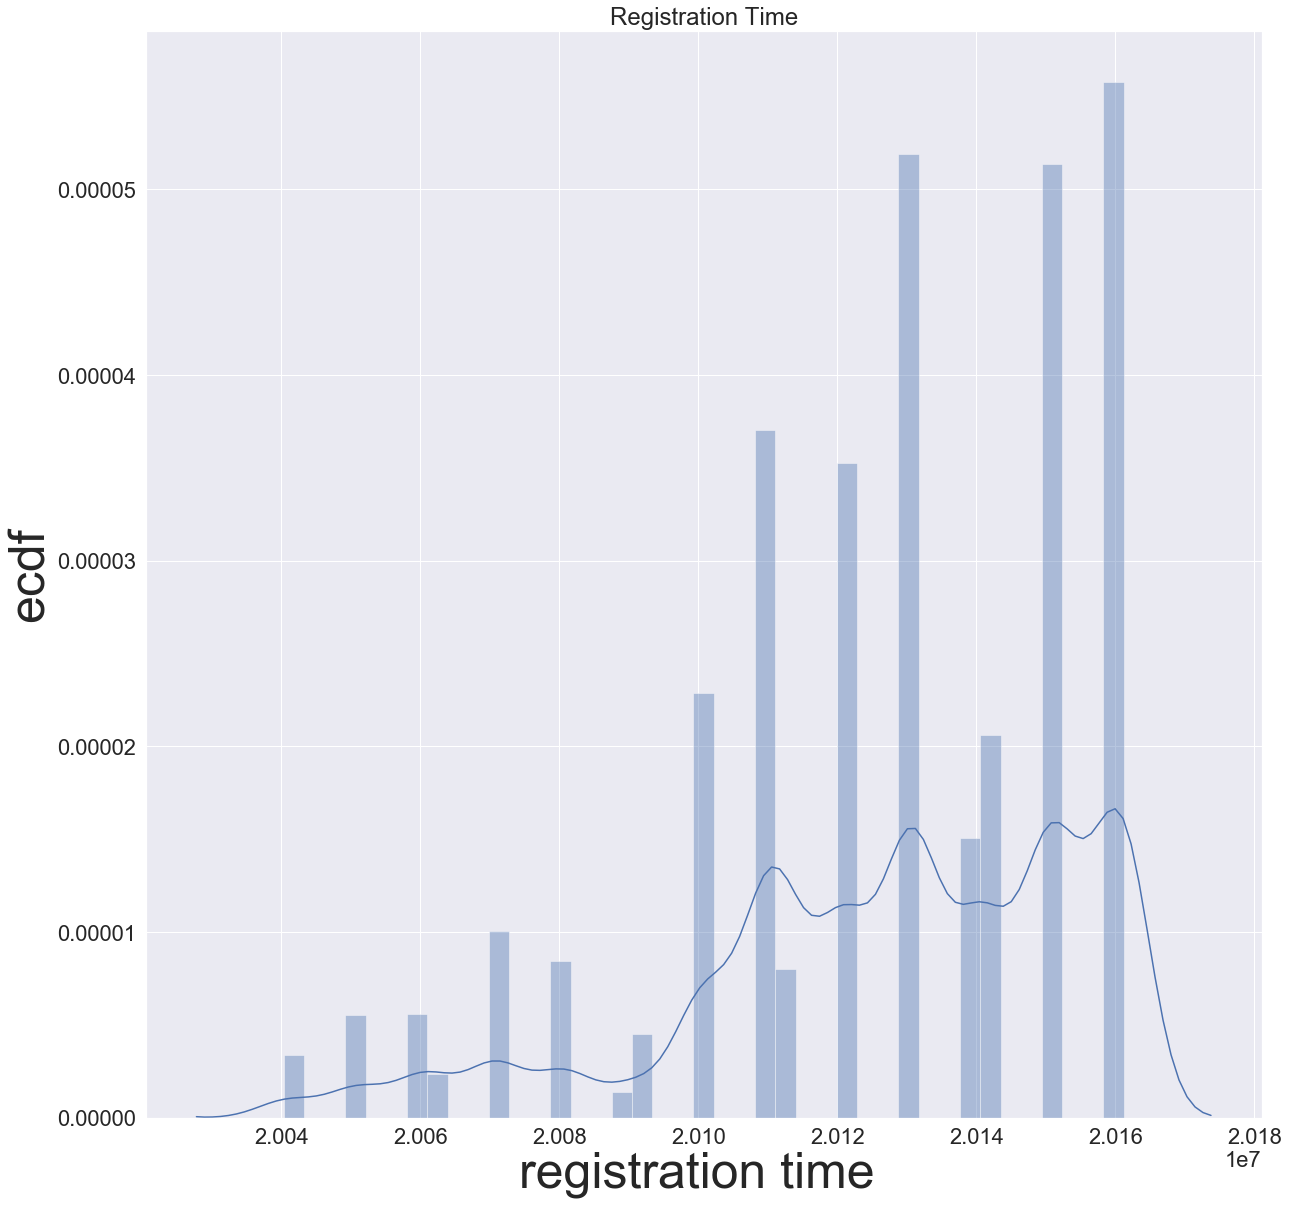

In [150]:
#plt.rcParams['font.size'] = 40.0
plt.figure(figsize = (20, 20)) 
sns.distplot(train_merged.registration_init_time)
sns.set(font_scale=2)
plt.ylabel('ecdf',fontsize=50)
plt.xlabel('registration time ' ,fontsize=50)
plt.title("Registration Time")

In [151]:
train_merged.describe()

,target,song_length,language,city,bd,registered_via,registration_init_time,expiration_date
count,19999.000000,2.845000e+03,2845.000000,19999.000000,19999.000000,19999.000000,1.999900e+04,1.999900e+04
mean,0.762188,2.443046e+05,17.517399,7.740437,17.763838,6.775539,2.012644e+07,2.017177e+07
std,0.425754,5.453625e+04,20.448697,6.403544,15.485040,2.297694,2.864186e+04,3.494504e+03
min,0.000000,5.944000e+03,-1.000000,1.000000,0.000000,3.000000,2.004033e+07,2.016021e+07
25%,1.000000,2.161370e+05,3.000000,1.000000,0.000000,4.000000,2.011062e+07,2.017091e+07
50%,1.000000,2.380500e+05,3.000000,5.000000,22.000000,7.000000,2.013072e+07,2.017093e+07
75%,1.000000,2.691650e+05,31.000000,13.000000,30.000000,9.000000,2.015072e+07,2.017101e+07
max,1.000000,1.802936e+06,59.000000,22.000000,111.000000,13.000000,2.016120e+07,2.019041e+07


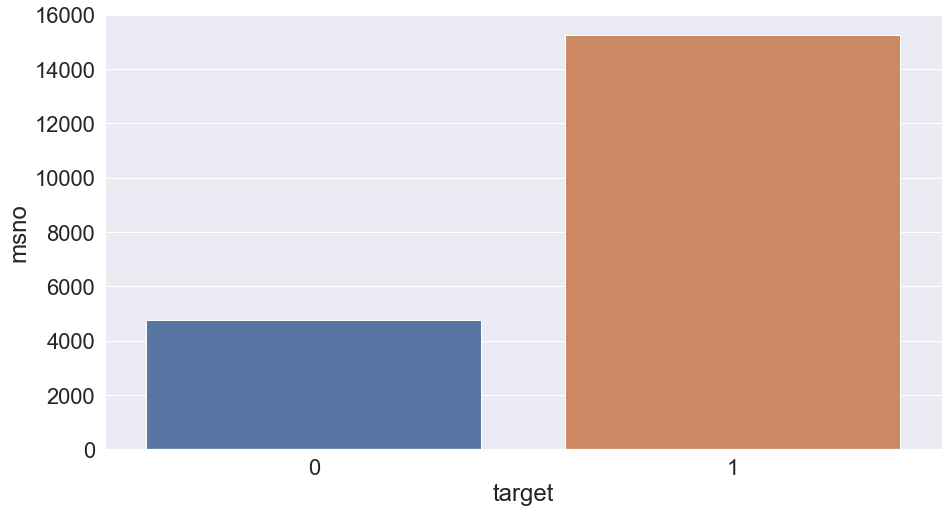

In [245]:
data = train_merged.groupby('target').aggregate({'msno':'count'}).reset_index()
a4_dims=(15,8)
fig,ax=plt.subplots(figsize=a4_dims)
ax= sns.barplot(x='target',y='msno',data=data)

   language   msno
0      -1.0     87
1       0.0  17154
2       3.0   1664
3      10.0     43
4      17.0     75
5      24.0     31
6      31.0    318
7      52.0    624
8      59.0      3


[Text(0, 0, '-1.0'),
 Text(0, 0, '0.0'),
 Text(0, 0, '3.0'),
 Text(0, 0, '10.0'),
 Text(0, 0, '17.0'),
 Text(0, 0, '24.0'),
 Text(0, 0, '31.0'),
 Text(0, 0, '52.0'),
 Text(0, 0, '59.0')]

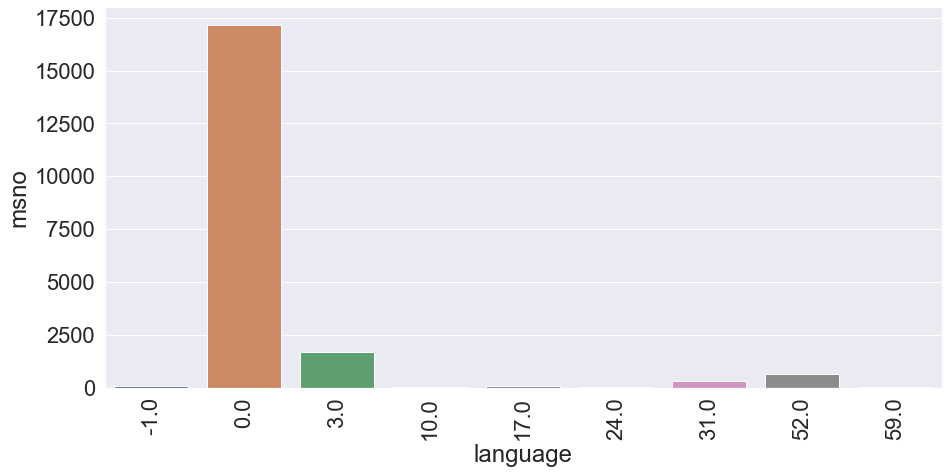

In [249]:
data = train_merged.groupby('language').aggregate({'msno':'count'}).reset_index()
print(data)
a4_dims=(15,7)
fig, ax= plt.subplots(figsize=a4_dims)
ax= sns.barplot(x='language', y='msno', data= data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22')]

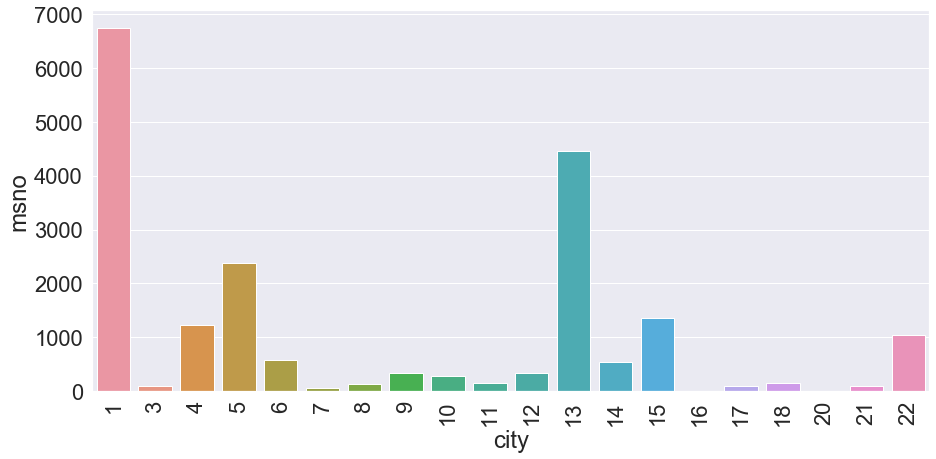

In [250]:
data = train_merged.groupby('city').aggregate({'msno':'count'}).reset_index()
a4_dims=(15,7)
fig, ax= plt.subplots(figsize=a4_dims)
ax= sns.barplot(x='city', y='msno', data= data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## Handeling Missing Values

In [152]:
##CODE TO CHECK IF ANY NULL VALUES ARE PRESENT
print(train_merged.isnull().any())

msno                      False
song_id                   False
source_system_tab          True
source_screen_name         True
source_type                True
target                    False
song_length                True
genre_ids                  True
artist_name                True
composer                   True
lyricist                   True
language                   True
city                      False
bd                        False
gender                     True
registered_via            False
registration_init_time    False
expiration_date           False
dtype: bool


In [153]:
def null_count(df):
    if(df.isnull().values.any()):
        for col in df.columns:
            if(df[col].isnull().any()):
                print(col,'--',df[col].isnull().sum())
null_count(train_merged)        

source_system_tab -- 67
source_screen_name -- 576
source_type -- 50
song_length -- 17154
genre_ids -- 17200
artist_name -- 17154
composer -- 17756
lyricist -- 18219
language -- 17154
gender -- 7712


In [154]:
train_merged.dtypes

msno                       object
song_id                    object
source_system_tab          object
source_screen_name         object
source_type                object
target                      int64
song_length               float64
genre_ids                  object
artist_name                object
composer                   object
lyricist                   object
language                  float64
city                        int64
bd                          int64
gender                     object
registered_via              int64
registration_init_time      int64
expiration_date             int64
dtype: object

In [155]:
pd.Series(train_merged.select_dtypes(include=object).columns)
train_merged.select_dtypes(include=object).isnull().values.any()
train_merged.select_dtypes(include=object).columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'genre_ids', 'artist_name', 'composer', 'lyricist',
       'gender'],
      dtype='object')

In [156]:
def fill_missing(df):
     while(df.isnull().values.any()):
        if(df.select_dtypes(include=object).isnull().values.any()):
            obcol=list(df.select_dtypes(include=['object']).columns)
            for col in obcol:
                print(col)
                df[col]=df[col].fillna('unknown')
        else:
            obcol=list(df.select_dtypes(include=['float64','int64']).columns)
            for col in obcol:
                df[col]=df[col].fillna(0)
fill_missing(train_merged)


msno
song_id
source_system_tab
source_screen_name
source_type
genre_ids
artist_name
composer
lyricist
gender


In [169]:
train_merged.head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,0.0,unknown,unknown,unknown,...,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,0.0,unknown,unknown,unknown,...,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,0.0,unknown,unknown,unknown,...,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,0.0,unknown,unknown,unknown,...,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,0.0,unknown,unknown,unknown,...,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,247803.0,1259,Desiigner,Sidney Selby| Adnan Khan,...,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,0.0,unknown,unknown,unknown,...,13,24,female,9,2011-05-25,2017-09-11,2011,5,25,2017
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,0.0,unknown,unknown,unknown,...,1,0,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,0.0,unknown,unknown,unknown,...,15,26,male,9,2011-11-07,2018-03-04,2011,11,7,2018
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,0.0,unknown,unknown,unknown,...,15,26,male,9,2011-11-07,2018-03-04,2011,11,7,2018


In [193]:
#Converting dates
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 19998
Data columns (total 24 columns):
msno                            19999 non-null category
song_id                         19999 non-null category
source_system_tab               19999 non-null category
source_screen_name              19999 non-null category
source_type                     19999 non-null category
target                          19999 non-null int64
song_length                     19999 non-null float64
genre_ids                       19999 non-null category
artist_name                     19999 non-null category
composer                        19999 non-null category
lyricist                        19999 non-null category
language                        19999 non-null float64
city                            19999 non-null int64
bd                              19999 non-null int64
gender                          19999 non-null category
registered_via                  19999 non-null int64
registrat

In [170]:
train_merged['registration_init_time']=pd.to_datetime(train_merged['registration_init_time'],format='%Y%m%d', errors='ignore')
train_merged['registration_init_time_year']=train_merged['registration_init_time'].dt.year
train_merged['registration_init_time_month']=train_merged['registration_init_time'].dt.month
train_merged['registration_init_time_day']=train_merged['registration_init_time'].dt.day

train_merged['expiration_date']=pd.to_datetime(train_merged['expiration_date'],format='%Y%m%d', errors='ignore')
train_merged['expiration_date_year']=train_merged.expiration_date.dt.year
train_merged['expiration_date_month']=train_merged.expiration_date.dt.month
train_merged['expiration_date_day']=train_merged.expiration_date.dt.day

#### Converting objects to Category

In [186]:
obcol=list(train_merged.select_dtypes(include=['object']).columns)
for col in obcol:
    train_merged[col]=train_merged[col].astype('category')
    
    

#### Converting dates to category

In [216]:
train_merged['registration_init_time'] = train_merged['registration_init_time'].astype('category')
train_merged['expiration_date'] = train_merged['expiration_date'].astype('category')
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 19998
Data columns (total 24 columns):
msno                            19999 non-null int16
song_id                         19999 non-null int16
source_system_tab               19999 non-null int8
source_screen_name              19999 non-null int8
source_type                     19999 non-null int8
target                          19999 non-null int64
song_length                     19999 non-null float64
genre_ids                       19999 non-null int8
artist_name                     19999 non-null int16
composer                        19999 non-null int16
lyricist                        19999 non-null int16
language                        19999 non-null float64
city                            19999 non-null int64
bd                              19999 non-null int64
gender                          19999 non-null int8
registered_via                  19999 non-null int64
registration_init_time          19999 non-nu

#### Converting Categorical features to codes



In [217]:
for col in list(train_merged.select_dtypes(include=['category']).columns):
    train_merged[col]=train_merged[col].cat.codes
train_merged.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 19998
Data columns (total 24 columns):
msno                            19999 non-null int16
song_id                         19999 non-null int16
source_system_tab               19999 non-null int8
source_screen_name              19999 non-null int8
source_type                     19999 non-null int8
target                          19999 non-null int64
song_length                     19999 non-null float64
genre_ids                       19999 non-null int8
artist_name                     19999 non-null int16
composer                        19999 non-null int16
lyricist                        19999 non-null int16
language                        19999 non-null float64
city                            19999 non-null int64
bd                              19999 non-null int64
gender                          19999 non-null int8
registered_via                  19999 non-null int64
registration_init_time          19999 non-nu

In [251]:
train_merged.describe()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,1.999900e+04,19999.000000,19999.000000,19999.000000,...,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,1218.856793,4843.799190,2.619931,7.453723,3.893945,0.762188,3.475406e+04,56.071204,368.507525,468.878494,...,1.066303,6.775539,891.857443,223.759438,2012.573429,6.878694,15.858893,2017.091455,8.416221,15.928646
std,699.766022,2823.092698,1.420143,2.856810,1.598455,0.425754,8.778422e+04,12.751666,73.134566,73.333146,...,0.837003,2.297694,454.787279,77.392673,2.866604,3.561271,8.666955,0.363042,2.455682,9.119160
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,3.000000,0.000000,0.000000,2004.000000,1.000000,1.000000,2016.000000,1.000000,1.000000
25%,614.000000,2408.500000,3.000000,7.000000,3.000000,1.000000,0.000000e+00,61.000000,368.000000,473.000000,...,0.000000,4.000000,527.000000,205.000000,2011.000000,4.000000,8.000000,2017.000000,9.000000,8.000000
50%,1226.000000,4761.000000,3.000000,7.000000,3.000000,1.000000,0.000000e+00,61.000000,368.000000,473.000000,...,1.000000,7.000000,901.000000,220.000000,2013.000000,7.000000,16.000000,2017.000000,9.000000,15.000000
75%,1806.500000,7245.000000,3.000000,7.000000,4.000000,1.000000,0.000000e+00,61.000000,368.000000,473.000000,...,2.000000,9.000000,1305.000000,231.000000,2015.000000,10.000000,23.000000,2017.000000,10.000000,23.000000
max,2462.000000,9812.000000,7.000000,17.000000,11.000000,1.000000,1.802936e+06,61.000000,700.000000,752.000000,...,2.000000,13.000000,1620.000000,469.000000,2016.000000,12.000000,31.000000,2019.000000,12.000000,31.000000


# Model BUILDING